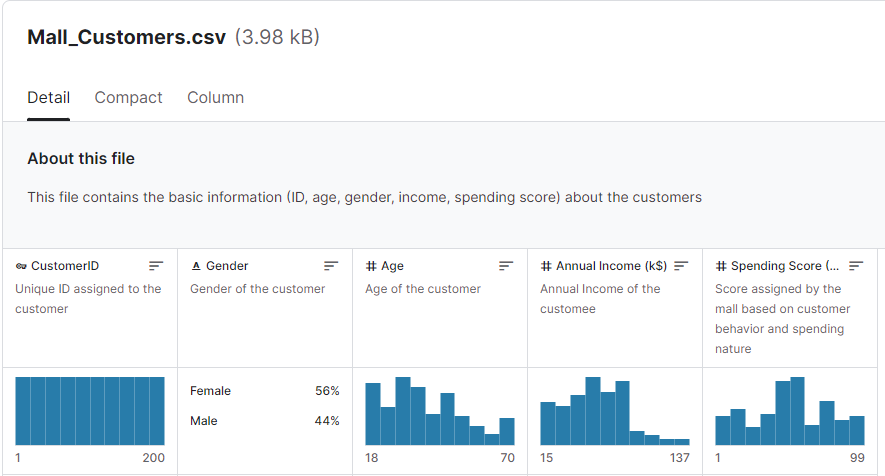

# Library Imports and Setup

In [19]:
# Install the mxnet library required for certain functionalities in SageMaker
!pip install mxnet

# AWS SageMaker and Boto3
import sagemaker
from sagemaker import get_execution_role, KMeans
from sagemaker.image_uris import retrieve
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
import boto3
from botocore.exceptions import ClientError
from sagemaker.tuner import IntegerParameter, CategoricalParameter, HyperparameterTuner
from sagemaker.amazon.common import write_numpy_to_dense_tensor
from sagemaker.inputs import TrainingInput

# Data Manipulation
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Additional Libraries
import tarfile
import mxnet as mx
import datetime
import json
import time
from tabulate import tabulate
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import io

# Setup and configuration for AWS SageMaker

In [2]:
# Initialize a SageMaker Session
# A SageMaker Session helps in managing the interactions with the AWS SageMaker service, such as creating and training models, and deploying endpoints.
sagemaker_session = sagemaker.Session()

# Retrieve the IAM role
# The IAM role is required by SageMaker to access AWS resources (e.g., S3 buckets) on your behalf.
role = get_execution_role()

# Identify the AWS Region of the SageMaker Session
# This information is used to ensure that resources are created in the same region as the SageMaker session.
region = sagemaker_session.boto_region_name

# Create Boto3 Clients for S3 and SageMaker
# These clients enable programmatic access to S3 and SageMaker services for operations like uploading data and creating training jobs.
s3_client = boto3.client('s3')
sagemaker_client = boto3.client('sagemaker')

# Retrieve the Docker image URI for the KMeans algorithm
# This URI is specific to the AWS region and is used to pull the appropriate image for training.
image_uri = retrieve('kmeans', region)

# Define the Default S3 Bucket for SageMaker
# SageMaker requires an S3 bucket to store training data, models, and outputs. Here, we use the session's default bucket.
bucket = sagemaker_session.default_bucket()

# Set the S3 Prefix for Storing Data
# The prefix is used to organize the data in the bucket, making it easier to manage and locate.
prefix = 'sagemaker/mall/kmeans-all'

# Output the IAM Role ARN and AWS Region for verification
print("Execution Role ARN:", role)
print("AWS Region:", region)

Execution Role ARN: arn:aws:iam::381492163284:role/LabRole
AWS Region: us-east-1


# Load and Preprocess the Dataset

In [3]:
# Step 1: Load the Dataset
# Load the mall customers dataset from a CSV file into a Pandas DataFrame.
# This allows for easy data manipulation and analysis.
df_mall = pd.read_csv('Mall_Customers.csv')

# Step 2: Select Relevant Features
# Focus on the features ''Annual Income (k$)', and 'Spending Score (1-100)' for analysis.
df_mall = df_mall[['Annual Income (k$)', 'Spending Score (1-100)']]

# Step 3: Convert Data for Machine Learning
# Convert the selected DataFrame into a NumPy array of type 'float32'.
# This conversion is necessary as most machine learning frameworks work efficiently with NumPy arrays.
data_np = df_mall.values.astype('float32')

# Step 4: Save Preprocessed Data
# Save the preprocessed dataset to a CSV file, without the index.
df_mall.to_csv('mall_data-one-a.csv', index=False)

# Confirming the data has been preprocessed and saved.
print("Preprocessed dataset saved as 'mall_data-one-a.csv'.")

# Display the first few rows of the processed dataset to verify the preprocessing steps.
print(df_mall.head())

Preprocessed dataset saved as 'mall_data-one-a.csv'.
   Annual Income (k$)  Spending Score (1-100)
0                  15                      39
1                  15                      81
2                  16                       6
3                  16                      77
4                  17                      40


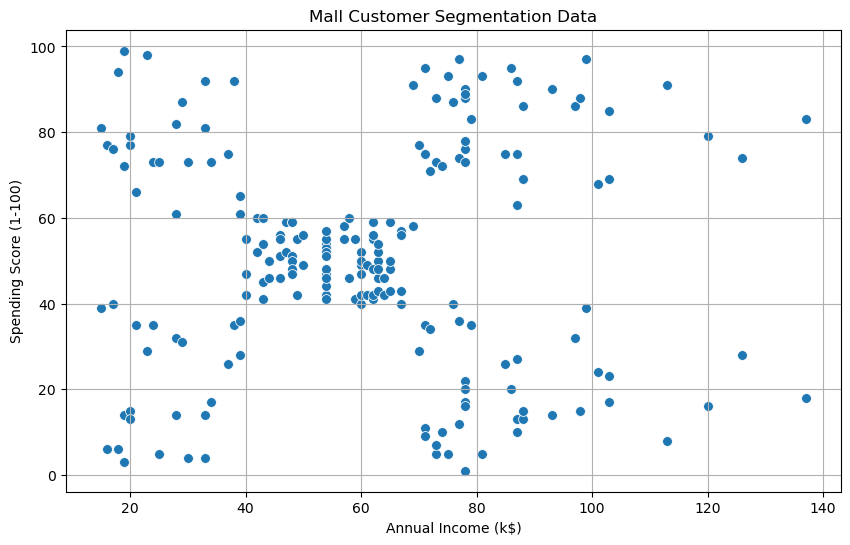

In [4]:
# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create scatter plot using Seaborn
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df_mall, s=50)

# Setting the title and labels of the plot
plt.title('Mall Customer Segmentation Data')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

# Enabling grid for better readability
plt.grid(True)

# Display the plot
plt.show()

# KMeans Model Training

In [5]:
# Define the range of k values for the KMeans clustering
# This range will determine how many models we train, each with a different number of clusters.
k_values = range(2, 8)

# Initialize lists to keep track of the S3 paths for the trained models and their training job names.
model_paths = []
training_jobs = []

# Set the output path in the S3 bucket for the trained models
# This path will be used to store the output (model artifacts) of each training job.
output_path = f's3://{sagemaker_session.default_bucket()}/sagemaker/mall/kmeans-one-a/output'

# Iterate over each k value to train a separate KMeans model for that number of clusters
for k in k_values:
    # Generate a unique job name for each training job based on the k value
    job_name = f'kmeans-mall-one-a-k-{k}'
    
    # Initialize the KMeans estimator from SageMaker with the specific k value
    # Configuration includes instance type, number of instances, and the specified k value.
    kmeans = KMeans(
        sagemaker_session=sagemaker_session,
        role=role,
        instance_count=1,
        instance_type='ml.m5.large',
        k=k,
        output_path=output_path,
        job_name=job_name,
        feature_dim=2  # Specify the number of features in the input data
    )
    
    # Start the training job for the KMeans model
    # We use 'wait=False' to start each training job asynchronously.
    kmeans.fit(kmeans.record_set(data_np), wait=False)
    training_jobs.append((k, kmeans.latest_training_job.name))

# After initiating all training jobs, we wait for each to complete and collect their model URIs
for k, job_name in training_jobs:
    # Wait for the completion of the training job
    sagemaker_client.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    
    # Retrieve the S3 URI of the model artifacts for the completed training job
    training_job_description = sagemaker_client.describe_training_job(TrainingJobName=job_name)
    model_s3_uri = training_job_description['ModelArtifacts']['S3ModelArtifacts']
    model_paths.append((k, model_s3_uri))

# Print the S3 paths of the model artifacts for all trained models
# This provides a clear reference to the location of each model for further analysis or deployment.
headers = ['k Value', 'S3 Model Artifact Path']
print(tabulate(model_paths, headers=headers))

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: kmeans-2024-03-17-21-17-43-095
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: kmeans-2024-03-17-21-17-43-556
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris

  k Value  S3 Model Artifact Path
---------  ---------------------------------------------------------------------------------------------------------------------------
        2  s3://sagemaker-us-east-1-381492163284/sagemaker/mall/kmeans-one-a/output/kmeans-2024-03-17-21-17-43-095/output/model.tar.gz
        3  s3://sagemaker-us-east-1-381492163284/sagemaker/mall/kmeans-one-a/output/kmeans-2024-03-17-21-17-43-556/output/model.tar.gz
        4  s3://sagemaker-us-east-1-381492163284/sagemaker/mall/kmeans-one-a/output/kmeans-2024-03-17-21-17-45-402/output/model.tar.gz
        5  s3://sagemaker-us-east-1-381492163284/sagemaker/mall/kmeans-one-a/output/kmeans-2024-03-17-21-17-46-084/output/model.tar.gz
        6  s3://sagemaker-us-east-1-381492163284/sagemaker/mall/kmeans-one-a/output/kmeans-2024-03-17-21-17-46-891/output/model.tar.gz
        7  s3://sagemaker-us-east-1-381492163284/sagemaker/mall/kmeans-one-a/output/kmeans-2024-03-17-21-17-48-352/output/model.tar.gz


# Determine K through Elbow Plot

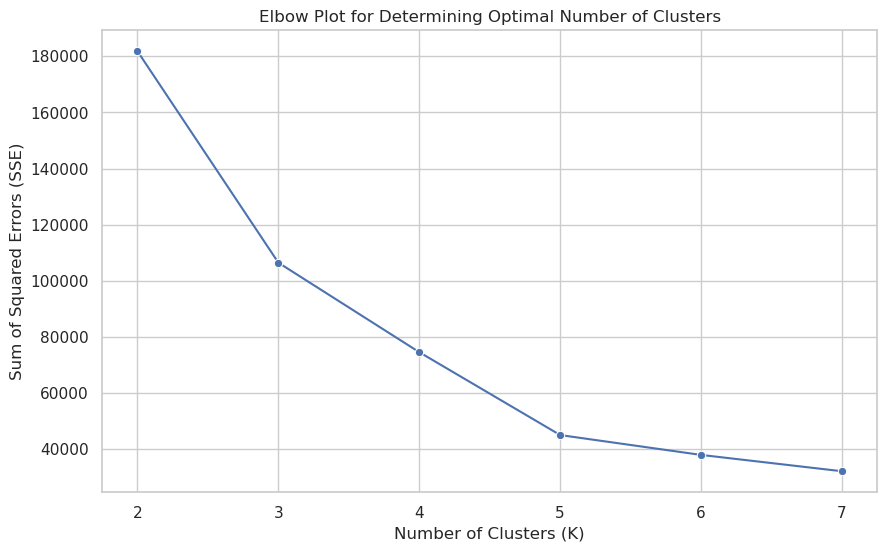

In [6]:
# List to store the Sum of Squared Errors (SSE) for each value of K
sse_values = []

# Iterate over each trained model's path to calculate SSE
for k, model_path in model_paths:
    try:
        # Download the model artifacts from S3
        local_path = f'/tmp/model-k-{k}.tar.gz'
        s3_client.download_file(sagemaker_session.default_bucket(), model_path.replace(f's3://{sagemaker_session.default_bucket()}/', ''), local_path)
        
        # Extract the model artifacts
        with tarfile.open(local_path) as tar:
            tar.extractall(path=f'/tmp/k-{k}')
        
        # Load the KMeans model parameters
        kmeans_model_params = mx.ndarray.load(f'/tmp/k-{k}/model_algo-1')
        centroids = kmeans_model_params[0].asnumpy()
        
        # Calculate distances from each point to each centroid
        distances = np.sqrt(((data_np - centroids[:, np.newaxis])**2).sum(axis=2))
        
        # Determine the closest centroid for each data point
        closest_centroids = np.argmin(distances, axis=0)
        
        # Calculate SSE for this value of K
        sse = np.sum((data_np - centroids[closest_centroids])**2)
        sse_values.append(sse)
    except Exception as e:
        print(f'Error processing model for K={k}: {e}')

# Create and display the Elbow Plot using seaborn and matplotlib
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=[k for k, _ in model_paths], y=sse_values, marker='o')
plt.title('Elbow Plot for Determining Optimal Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks([k for k, _ in model_paths])
plt.show()

# Determine K through using Silhouette Method

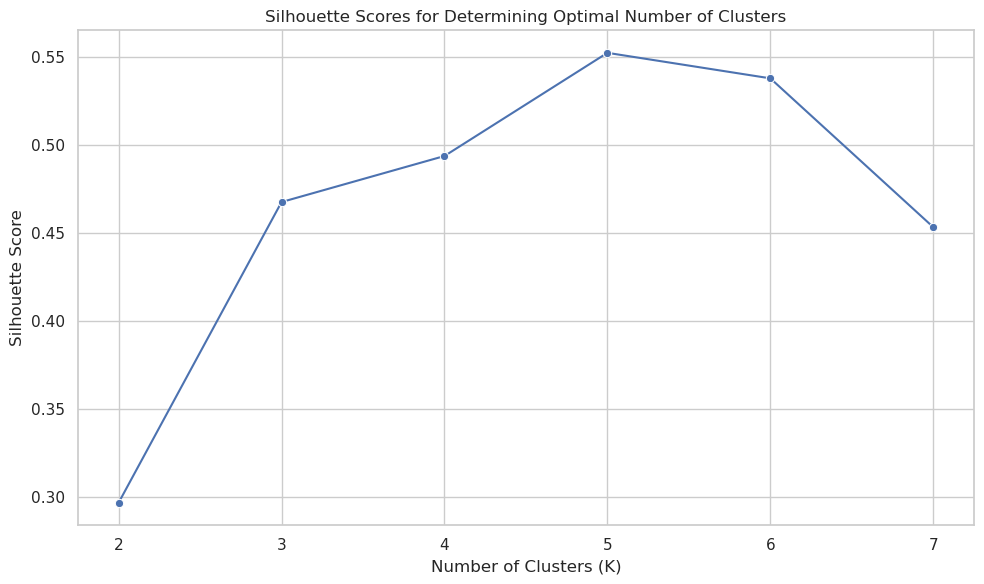

In [7]:
# List to store the silhouette scores for each value of K
silhouette_scores = []

# Iterate over each trained model's path to calculate its silhouette score
for k, model_path in model_paths:
    try:
        # Download the model artifacts from S3
        local_path = f'/tmp/model-k-{k}.tar.gz'
        s3_client.download_file(sagemaker_session.default_bucket(), model_path.replace(f's3://{sagemaker_session.default_bucket()}/', ''), local_path)
        
        # Extract the model artifacts
        with tarfile.open(local_path) as tar:
            tar.extractall(path=f'/tmp/k-{k}')
        
        # Load the KMeans model parameters
        kmeans_model_params = mx.ndarray.load(f'/tmp/k-{k}/model_algo-1')
        centroids = kmeans_model_params[0].asnumpy()
        
        # Calculate distances from each point to each centroid
        distances = np.sqrt(((data_np - centroids[:, np.newaxis])**2).sum(axis=2))
        
        # Determine the closest centroid for each data point
        closest_centroids = np.argmin(distances, axis=0)
        
        # Calculate the silhouette score for this value of K
        silhouette_score_value = silhouette_score(data_np, closest_centroids)
        silhouette_scores.append(silhouette_score_value)
    except Exception as e:
        print(f'Error processing model for K={k}: {e}')

# Plot the silhouette scores for different values of K, if available
if silhouette_scores:  # Ensure the list is not empty
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=[k for k, _ in model_paths], y=silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Determining Optimal Number of Clusters')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.tight_layout()  # Adjust the layout to make sure everything fits without overlap
    plt.show()
else:
    print("No silhouette scores to plot.")

# KMeans Hyperparameter Tuning (HPT)

INFO:sagemaker:Creating hyperparameter tuning job with name: kmeans-240317-2138


...............................................................................................!
!

2024-03-17 21:43:53 Starting - Found matching resource for reuse
2024-03-17 21:43:53 Downloading - Downloading the training image
2024-03-17 21:43:53 Training - Training image download completed. Training in progress.
2024-03-17 21:43:53 Uploading - Uploading generated training model
2024-03-17 21:43:53 Completed - Resource reused by training job: kmeans-240317-2138-005-913b0848
Best hyperparameters:
_tuning_objective_metric: test:msd
epochs: 5
extra_center_factor: 4
feature_dim: 2
init_method: random
k: 5
mini_batch_size: 12490
Model Metrics for Best Model:
SSE: 44949.5


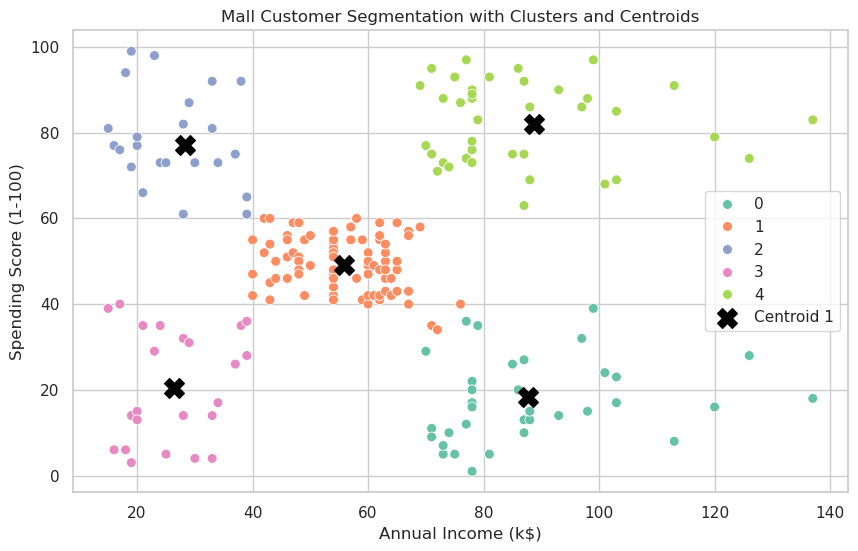

In [20]:
# Specify the best K value
best_k = 5

# Initialize KMeans estimator with specified configuration and hyperparameters
kmeans = sagemaker.estimator.Estimator(
    image_uri=image_uri,  # Docker image URI for KMeans algorithm
    role=role,  # IAM role with permissions for SageMaker operations
    instance_count=1,  # Number of EC2 instances for training
    instance_type='ml.m5.large',  # Type of EC2 instance to use for training
    output_path=f's3://{bucket}/{prefix}/output',  # S3 location for saving trained model artifacts
    sagemaker_session=sagemaker_session,  # SageMaker session object
    hyperparameters={
        'k': best_k,  # Desired number of clusters
        'feature_dim': '2'  # Number of features in input data
    }
)

# Define hyperparameter ranges for tuning
hyperparameter_ranges = {
    'extra_center_factor': IntegerParameter(4, 10),
    'init_method': CategoricalParameter(['random', 'kmeans++']),
    'epochs': IntegerParameter(1, 10),
    'mini_batch_size': IntegerParameter(3000, 15000)
}

# Metric to optimize during hyperparameter tuning
objective_metric_name = 'test:msd'

# Split data into training and testing sets
train_data, test_data = train_test_split(data_np, test_size=0.2, random_state=42)

# Convert and upload training data to S3 in recordIO-wrapped protobuf format
buf = io.BytesIO()
write_numpy_to_dense_tensor(buf, train_data, labels=None)
buf.seek(0)
train_key = f'{prefix}/train/train_data.pbr'
s3_client.upload_fileobj(buf, bucket, train_key)
s3_train_data = f's3://{bucket}/{train_key}'

# Convert and upload testing data to S3 in the same format
buf = io.BytesIO()
write_numpy_to_dense_tensor(buf, test_data, labels=None)
buf.seek(0)
test_key = f'{prefix}/test/test_data.pbr'
s3_client.upload_fileobj(buf, bucket, test_key)
s3_test_data = f's3://{bucket}/{test_key}'

# Define training and testing inputs for SageMaker
train_input = TrainingInput(s3_data=s3_train_data, content_type='application/x-recordio-protobuf')
test_input = TrainingInput(s3_data=s3_test_data, content_type='application/x-recordio-protobuf')

# Configure and initialize hyperparameter tuner
tuner = HyperparameterTuner(
    estimator=kmeans,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    objective_type='Minimize',
    max_jobs=10,
    max_parallel_jobs=2
)

# Start hyperparameter tuning job
tuner.fit({'train': train_input, 'test': test_input})
tuner.wait()  # Block until tuning job completes

# Fetch the best model and its hyperparameters
best_estimator = tuner.best_estimator()
print("Best hyperparameters:")
for key, value in best_estimator.hyperparameters().items():
    print(f"{key}: {value}")

# Download the best model artifacts from S3
best_model_s3_uri = best_estimator.model_data
local_path = '/tmp/best_model.tar.gz'
s3_client.download_file(Bucket=bucket, Key=best_model_s3_uri.replace(f's3://{bucket}/', ''), Filename=local_path)

# Extract model parameters
with tarfile.open(local_path) as tar:
    tar.extractall(path='/tmp/best_model')

# Load the KMeans model parameters and compute cluster assignments
kmeans_best_params = mx.ndarray.load('/tmp/best_model/model_algo-1')
centroids_best = kmeans_best_params[0].asnumpy()
distances_best = np.sqrt(((data_np - centroids_best[:, np.newaxis])**2).sum(axis=2))
cluster_labels = np.argmin(distances_best, axis=0)

# Add cluster labels to the original DataFrame
df_mall['Cluster'] = cluster_labels

# Compute model metrics, e.g., Sum of Squared Errors (SSE)
sse_best = np.sum((data_np - centroids_best[cluster_labels])**2)
print(f"Model Metrics for Best Model:\nSSE: {sse_best}")

# Visualize the clustering results
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_mall, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', palette='Set2', s=50)
for i, centroid in enumerate(centroids_best):
    plt.scatter(centroid[0], centroid[1], s=200, c='black', marker='X', label=f'Centroid {i+1}' if i == 0 else None)
plt.title('Mall Customer Segmentation with Clusters and Centroids')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()


# Model Deployment to SageMaker Endpoint

In [21]:
# Specify the endpoint name
endpoint_name = 'mall-kmeans-one-a-HPT'

# Specify the endpoint configuration name
endpoint_config_name = 'mall-kmeans-one-a-HPT'

# Create a SageMaker client
sagemaker_client = boto3.client('sagemaker')
# Check if the endpoint configuration already exists
try:
    sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
    print(f'Endpoint configuration "{endpoint_config_name}" already exists. Deleting...')
    sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)

    # Wait for the endpoint configuration to be deleted
    while True:
        try:
            sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
            print("Waiting for endpoint configuration to be deleted...")
            time.sleep(5)  # Wait for 5 seconds before checking again
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint configuration "{endpoint_config_name}" deleted.')
                break  # Exit the loop if the endpoint configuration is deleted
            else:
                raise

except ClientError as e:
    if e.response['Error']['Code'] == 'ValidationException':
        print(f'Endpoint configuration "{endpoint_config_name}" does not exist.')
    else:
        raise

# Check if the endpoint already exists
try:
    sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
    print(f'Endpoint "{endpoint_name}" already exists. Deleting...')
    sagemaker_client.delete_endpoint(EndpointName=endpoint_name)

    # Wait for the endpoint to be deleted
    while True:
        try:
            sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
            print("Waiting for endpoint to be deleted...")
            time.sleep(5)  # Wait for 5 seconds before checking again
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint "{endpoint_name}" deleted.')
                break  # Exit the loop if the endpoint is deleted
            else:
                raise

except ClientError as e:
    if e.response['Error']['Code'] == 'ValidationException':
        print(f'Endpoint "{endpoint_name}" does not exist.')
    else:
        raise

# Find the S3 URI for the best model
best_model_s3_uri = next(path for k, path in model_paths if k == best_k)

# Create a SageMaker Model object with the best model artifacts
best_model = Model(model_data=best_model_s3_uri,
                   image_uri=image_uri,
                   role=role,
                   sagemaker_session=sagemaker_session)

# Deploy the model as an endpoint
best_model.deploy(initial_instance_count=1, instance_type='ml.t2.medium', endpoint_name=endpoint_name)


Endpoint configuration "mall-kmeans-one-a-HPT" already exists. Deleting...
Endpoint configuration "mall-kmeans-one-a-HPT" deleted.
Endpoint "mall-kmeans-one-a-HPT" already exists. Deleting...
Waiting for endpoint to be deleted...
Waiting for endpoint to be deleted...


INFO:sagemaker:Creating model with name: kmeans-2024-03-17-22-01-55-051


Endpoint "mall-kmeans-one-a-HPT" deleted.


INFO:sagemaker:Creating endpoint-config with name mall-kmeans-one-a-HPT
INFO:sagemaker:Creating endpoint with name mall-kmeans-one-a-HPT


------------!

# Cluster Associations and Centroids

In [22]:
# Create a Predictor object for the deployed endpoint
predictor = Predictor(endpoint_name=endpoint_name, serializer=CSVSerializer())

while True:
    # Prompt for Annual Income and Spending Score
    annual_income = input("Enter Annual Income (k$) or type 'quit' to exit: ")
    if annual_income.lower() == 'quit':
        break
    spending_score = input("Enter Spending Score (1-100) or type 'quit' to exit: ")
    if spending_score.lower() == 'quit':
        break

    # Prepare the data for prediction
    data = f'{annual_income},{spending_score}\n'

    # Make prediction
    response = predictor.predict(data)

    # Parse the prediction response
    response_json = json.loads(response)
    cluster = response_json['predictions'][0]['closest_cluster']
    distance = response_json['predictions'][0]['distance_to_cluster']

    # Print the cluster assignment
    print(f"The data point belongs to Cluster {int(cluster)} with a distance of {distance:.2f} to the cluster center.")

print("Program exited.")


Enter Annual Income (k$) or type 'quit' to exit:  20
Enter Spending Score (1-100) or type 'quit' to exit:  35


The data point belongs to Cluster 3 with a distance of 15.94 to the cluster center.


Enter Annual Income (k$) or type 'quit' to exit:  quit


Program exited.


# Delete the Endpoint and Endpoint Config

In [23]:
# Prompt for confirmation before deleting the endpoint and endpoint configuration
confirmation = input("Are you sure you want to delete the endpoint and endpoint configuration? (yes/no): ")

if confirmation.lower() == 'yes':
    # Create a SageMaker client
    sagemaker_client = boto3.client('sagemaker')

    # Check if the endpoint configuration already exists
    try:
        sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
        print(f'Endpoint configuration "{endpoint_config_name}" already exists. Deleting...')
        sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
        print(f'Endpoint configuration "{endpoint_config_name}" deleted.')
    except ClientError as e:
        if e.response['Error']['Code'] == 'ValidationException':
            print(f'Endpoint configuration "{endpoint_config_name}" does not exist.')
        else:
            raise

    # Check if the endpoint already exists
    try:
        sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
        print(f'Endpoint "{endpoint_name}" already exists. Deleting...')
        sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
        print(f'Endpoint "{endpoint_name}" deleted.')
    except ClientError as e:
        if e.response['Error']['Code'] == 'ValidationException':
            print(f'Endpoint "{endpoint_name}" does not exist.')
        else:
            raise
else:
    print("Deletion cancelled.")


Are you sure you want to delete the endpoint and endpoint configuration? (yes/no):  yes


Endpoint configuration "mall-kmeans-one-a-HPT" already exists. Deleting...
Endpoint configuration "mall-kmeans-one-a-HPT" deleted.
Endpoint "mall-kmeans-one-a-HPT" already exists. Deleting...
Endpoint "mall-kmeans-one-a-HPT" deleted.
